This notebook follows the [CRISP-DM](https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining) approach for data science projects.

# 1) Business Understanding
- DengAI is part of a [DrivenData competition](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/80/)
- Goal: **Predict weekly dengue fever cases in Iquitos (Peru) and San Juan (Puerto Rico) based on climatology data**
- From the description:
    - Dengue fever is a mosquito-borne disease that occurs in tropical and sub-tropical parts of the world. In mild cases, symptoms are similar to the flu: fever, rash, and muscle and joint pain. In severe cases, dengue fever can cause severe bleeding, low blood pressure, and even death.
    - Because it is carried by mosquitoes, the **transmission dynamics of dengue are related to climate variables such as temperature and precipitation**.
    - These days many of the nearly half billion cases per year are occurring in Latin America.
- Objective is to minimize Mean Absolute Error (MAE) of predictions

# 2) Data Understanding
### Data sources
- Included measurements
    - NOAA's GHCN daily climate data weather station measurements
    - PERSIANN satellite precipitation measurements (0.25x0.25 degree scale)
    - NOAA's NCEP Climate Forecast System Reanalysis measurements (0.5x0.5 degree scale)
    - Satellite vegetation - Normalized difference vegetation index (NDVI) - NOAA's CDR Normalized Difference Vegetation Index (0.5x0.5 degree scale) measurements
- For detailed feature descriptions see [here](https://www.drivendata.org/competitions/44/dengai-predicting-disease-spread/page/82/).

In [14]:
import logging

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow.keras import layers
import kerastuner

import statsmodels.api as sm
import scipy.stats
from scipy.fft import rfft, rfftfreq

logging.getLogger('tensorflow').setLevel(logging.CRITICAL)     # to avoid a lot of noise in the output

SEED = 1
tf.random.set_seed(SEED)   # set random seed for reproducibility

BASE_PATH = r"C:\Users\Daniel\Documents\Studium\8. Semester (SS 2021)\Data Mining and Applications\Project\Data"
features_train = pd.read_csv(BASE_PATH + "/dengue_features_train.csv")
labels_train = pd.read_csv(BASE_PATH + "/dengue_labels_train.csv")
features_test = pd.read_csv(BASE_PATH + "/dengue_features_test.csv")

print("Dependencies and data imported.")

Dependencies and data imported.


In [2]:
features_train

city  year  weekofyear week_start_date   ndvi_ne   ndvi_nw   ndvi_se  \
0      sj  1990          18      1990-04-30  0.122600  0.103725  0.198483   
1      sj  1990          19      1990-05-07  0.169900  0.142175  0.162357   
2      sj  1990          20      1990-05-14  0.032250  0.172967  0.157200   
3      sj  1990          21      1990-05-21  0.128633  0.245067  0.227557   
4      sj  1990          22      1990-05-28  0.196200  0.262200  0.251200   
...   ...   ...         ...             ...       ...       ...       ...   
1451   iq  2010          21      2010-05-28  0.342750  0.318900  0.256343   
1452   iq  2010          22      2010-06-04  0.160157  0.160371  0.136043   
1453   iq  2010          23      2010-06-11  0.247057  0.146057  0.250357   
1454   iq  2010          24      2010-06-18  0.333914  0.245771  0.278886   
1455   iq  2010          25      2010-06-25  0.298186  0.232971  0.274214   

       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  ...  \
0     0.177617                 12.42             297.572857  ...   
1     0.155486                 22.82             298.211429  ...   
2     0.170843                 34.54             298.781429  ...   
3     0.235886                 15.36             298.987143  ...   
4     0.247340                  7.52             299.518571  ...   
...        ...                   ...                    ...  ...   
1451  0.292514                 55.30             299.334286  ...   
1452  0.225657                 86.47             298.330000  ...   
1453  0.233714                 58.94             296.598571  ...   
1454  0.325486                 59.67             296.345714  ...   
1455  0.315757                 63.22             298.097143  ...   

      reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
0                               32.00                             73.365714   
1                               17.94                             77.368571   
2                               26.10                             82.052857   
3                               13.90                             80.337143   
4                               12.20                             80.460000   
...                               ...                                   ...   
1451                            45.00                             88.765714   
1452                           207.10                             91.600000   
1453                            50.60                             94.280000   
1454                            62.33                             94.660000   
1455                            36.90                             89.082857   

      reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
0                            12.42                              14.012857   
1                            22.82                              15.372857   
2                            34.54                              16.848571   
3                            15.36                              16.672857   
4                             7.52                              17.210000   
...                            ...                                    ...   
1451                         55.30                              18.485714   
1452                         86.47                              18.070000   
1453                         58.94                              17.008571   
1454                         59.67                              16.815714   
1455                         63.22                              17.355714   

      reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
0              2.628571           25.442857                 6.900000   
1              2.371429           26.714286                 6.371429   
2              2.300000           26.714286                 6.485714   
3              2.428571           27.471429                 6.771429   
4              3.014286      

In [3]:
features_train.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

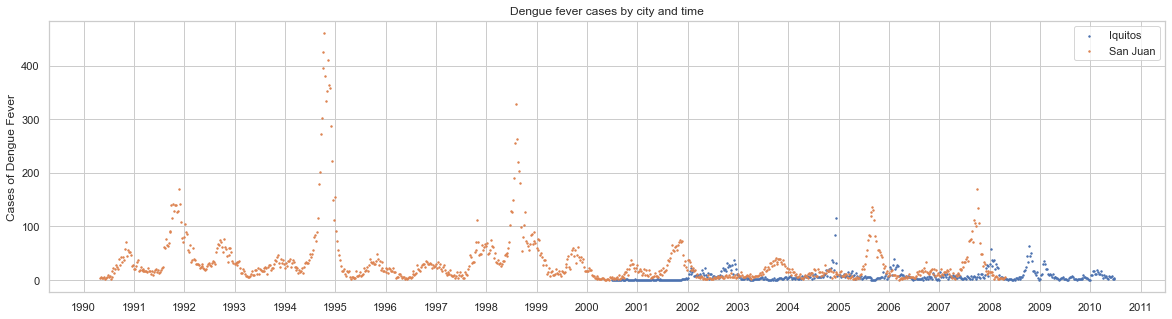

In [15]:
# Use subsets of data (one for each city)
X_iquitos = features_train[features_train["city"] == "iq"]
X_san_juan = features_train[features_train["city"] == "sj"]
y_iquitos = labels_train["total_cases"][X_iquitos.index]
y_san_juan = labels_train["total_cases"][X_san_juan.index]

train_datetime_index = pd.to_datetime(features_train["week_start_date"])

fig, ax = plt.subplots()
fig.set_size_inches((20, 5))
ax.scatter(x=train_datetime_index[y_iquitos.index], y=y_iquitos, s=2, label="Iquitos")
ax.scatter(x=train_datetime_index[y_san_juan.index], y=y_san_juan, s=2, label="San Juan")
ax.legend()
ax.set_ylabel("Cases of Dengue Fever")
ax.set_title("Dengue fever cases by city and time")

# Show all years in x axis
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

## Appearing values and value ranges

### Summary statistics

In [5]:
features_train.describe()

year   weekofyear      ndvi_ne      ndvi_nw      ndvi_se  \
count  1456.000000  1456.000000  1262.000000  1404.000000  1434.000000   
mean   2001.031593    26.503434     0.142294     0.130553     0.203783   
std       5.408314    15.019437     0.140531     0.119999     0.073860   
min    1990.000000     1.000000    -0.406250    -0.456100    -0.015533   
25%    1997.000000    13.750000     0.044950     0.049217     0.155087   
50%    2002.000000    26.500000     0.128817     0.121429     0.196050   
75%    2005.000000    39.250000     0.248483     0.216600     0.248846   
max    2010.000000    53.000000     0.508357     0.454429     0.538314   

           ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
count  1434.000000           1443.000000            1446.000000   
mean      0.202305             45.760388             298.701852   
std       0.083903             43.715537               1.362420   
min      -0.063457              0.000000             294.635714   
25%       0.144209              9.800000             297.658929   
50%       0.189450             38.340000             298.646429   
75%       0.246982             70.235000             299.833571   
max       0.546017            390.600000             302.200000   

       reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  ...  \
count            1446.000000                  1446.000000  ...   
mean              299.225578                   295.246356  ...   
std                 1.261715                     1.527810  ...   
min               294.892857                   289.642857  ...   
25%               298.257143                   294.118929  ...   
50%               299.289286                   295.640714  ...   
75%               300.207143                   296.460000  ...   
max               302.928571                   298.450000  ...   

       reanalysis_precip_amt_kg_per_m2  reanalysis_relative_humidity_percent  \
count                      1446.000000                           1446.000000   
mean                         40.151819                             82.161959   
std                          43.434399                              7.153897   
min                           0.000000                             57.787143   
25%                          13.055000                             77.177143   
50%                          27.245000                             80.301429   
75%                          52.200000                             86.357857   
max                         570.500000                             98.610000   

       reanalysis_sat_precip_amt_mm  reanalysis_specific_humidity_g_per_kg  \
count                   1443.000000                            1446.000000   
mean                      45.760388                              16.746427   
std                       43.715537                               1.542494   
min                        0.000000                              11.715714   
25%                        9.800000                              15.557143   
50%                       38.340000                              17.087143   
75%                       70.235000                              17.978214   
max                      390.600000                              20.461429   

       reanalysis_tdtr_k  station_avg_temp_c  station_diur_temp_rng_c  \
count        1446.000000         1413.000000              1413.000000   
mean            4.903754           27.185783                 8.059328   
std             3.546445            1.292347                 2.128568   
min             1.357143           21.400000                 4.528571   
25%             2.328571           26.300000                 6.514286   
50%             2.857143           27.414286                 7.300000   
75%             7.625000           28.157143                 9.566667   
max            16.028571           30.800000                15.800000   

       station_max_temp_c  station_min_temp_c  station_precip_mm  

### Violinplots

#### Humidity

Text(0.5, 1.0, 'Humidity [in % and g/kg]')

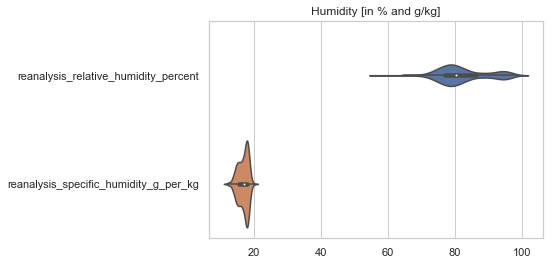

In [8]:
ax = sns.violinplot(data=features_train[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']],
                    orient="h")
ax.set_title("Humidity [in % and g/kg]")

Text(0.5, 1.0, 'Humidity')

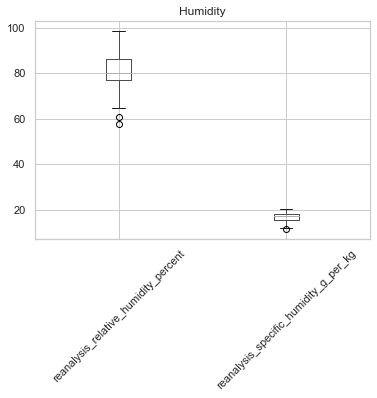

In [9]:
# Boxplot as comparison
fig, ax = plt.subplots()
features_train[['reanalysis_relative_humidity_percent', 'reanalysis_specific_humidity_g_per_kg']].boxplot(rot=45)
ax.set_title("Humidity")

#### Temperature

<ipython-input-16-0172efa4f566>:17: UserWarning:

FixedFormatter should only be used together with FixedLocator



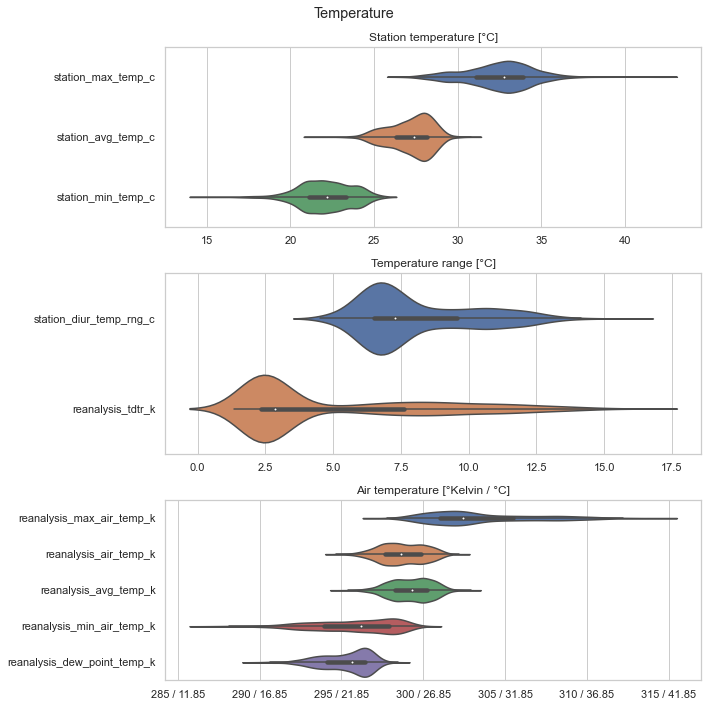

In [16]:
fig, ax = plt.subplots(3, 1)
plt.suptitle("Temperature")
fig.set_size_inches((10, 10))

temp_plt1 = sns.violinplot(data=features_train[['station_max_temp_c', 'station_avg_temp_c', 'station_min_temp_c']],
                           orient="h", ax=ax[0])
temp_plt1.set_title("Station temperature [°C]")
temp_plt2 = sns.violinplot(data=features_train[['station_diur_temp_rng_c', 'reanalysis_tdtr_k']],
                           orient="h", ax=ax[1])
temp_plt2.set_title("Temperature range [°C]")
temp_plt3 = sns.violinplot(data=features_train[['reanalysis_max_air_temp_k', 'reanalysis_air_temp_k', 'reanalysis_avg_temp_k',
                                                'reanalysis_min_air_temp_k', 'reanalysis_dew_point_temp_k']],
                           orient="h", ax=ax[2])
temp_plt3.set_title("Air temperature [°Kelvin / °C]")
# Air temperature values are given in the data in °Kelvin.
# For convenience and better comparability, this plot also shows the °Celsius values.
temp_plt3.set_xticklabels(["", "285 / 11.85", "290 / 16.85", "295 / 21.85", "300 / 26.85", "305 / 31.85", "310 / 36.85", "315 / 41.85"])

fig.tight_layout()

#### Precipitation

Text(0.5, 1.0, 'Precipitation [in mm and kg/m²]')

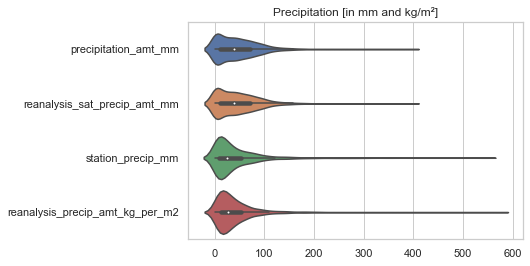

In [7]:
ax = sns.violinplot(data=features_train[['precipitation_amt_mm',
                                         'reanalysis_sat_precip_amt_mm',
                                         'station_precip_mm',
                                         'reanalysis_precip_amt_kg_per_m2']],
               orient="h")
ax.set_title("Precipitation [in mm and kg/m²]")

#### Vegetation
Using satellite images to compute Normalized Difference Vegetation Index (NDVI), indicating whether live green vegetation is present.

Text(0.5, 0, 'Normalized difference vegetation index [between -1 and 1]')

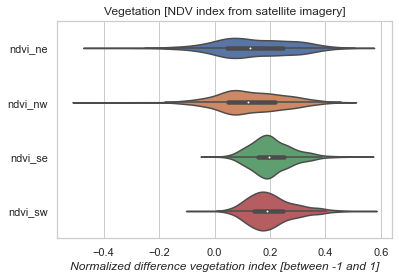

In [10]:
ax = sns.violinplot(data=features_train[['ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw']],
                    orient="h")
ax.set_title("Vegetation [NDV index from satellite imagery]")
ax.set_xlabel("Normalized difference vegetation index [between -1 and 1]", fontstyle="italic")

### Distribution over time

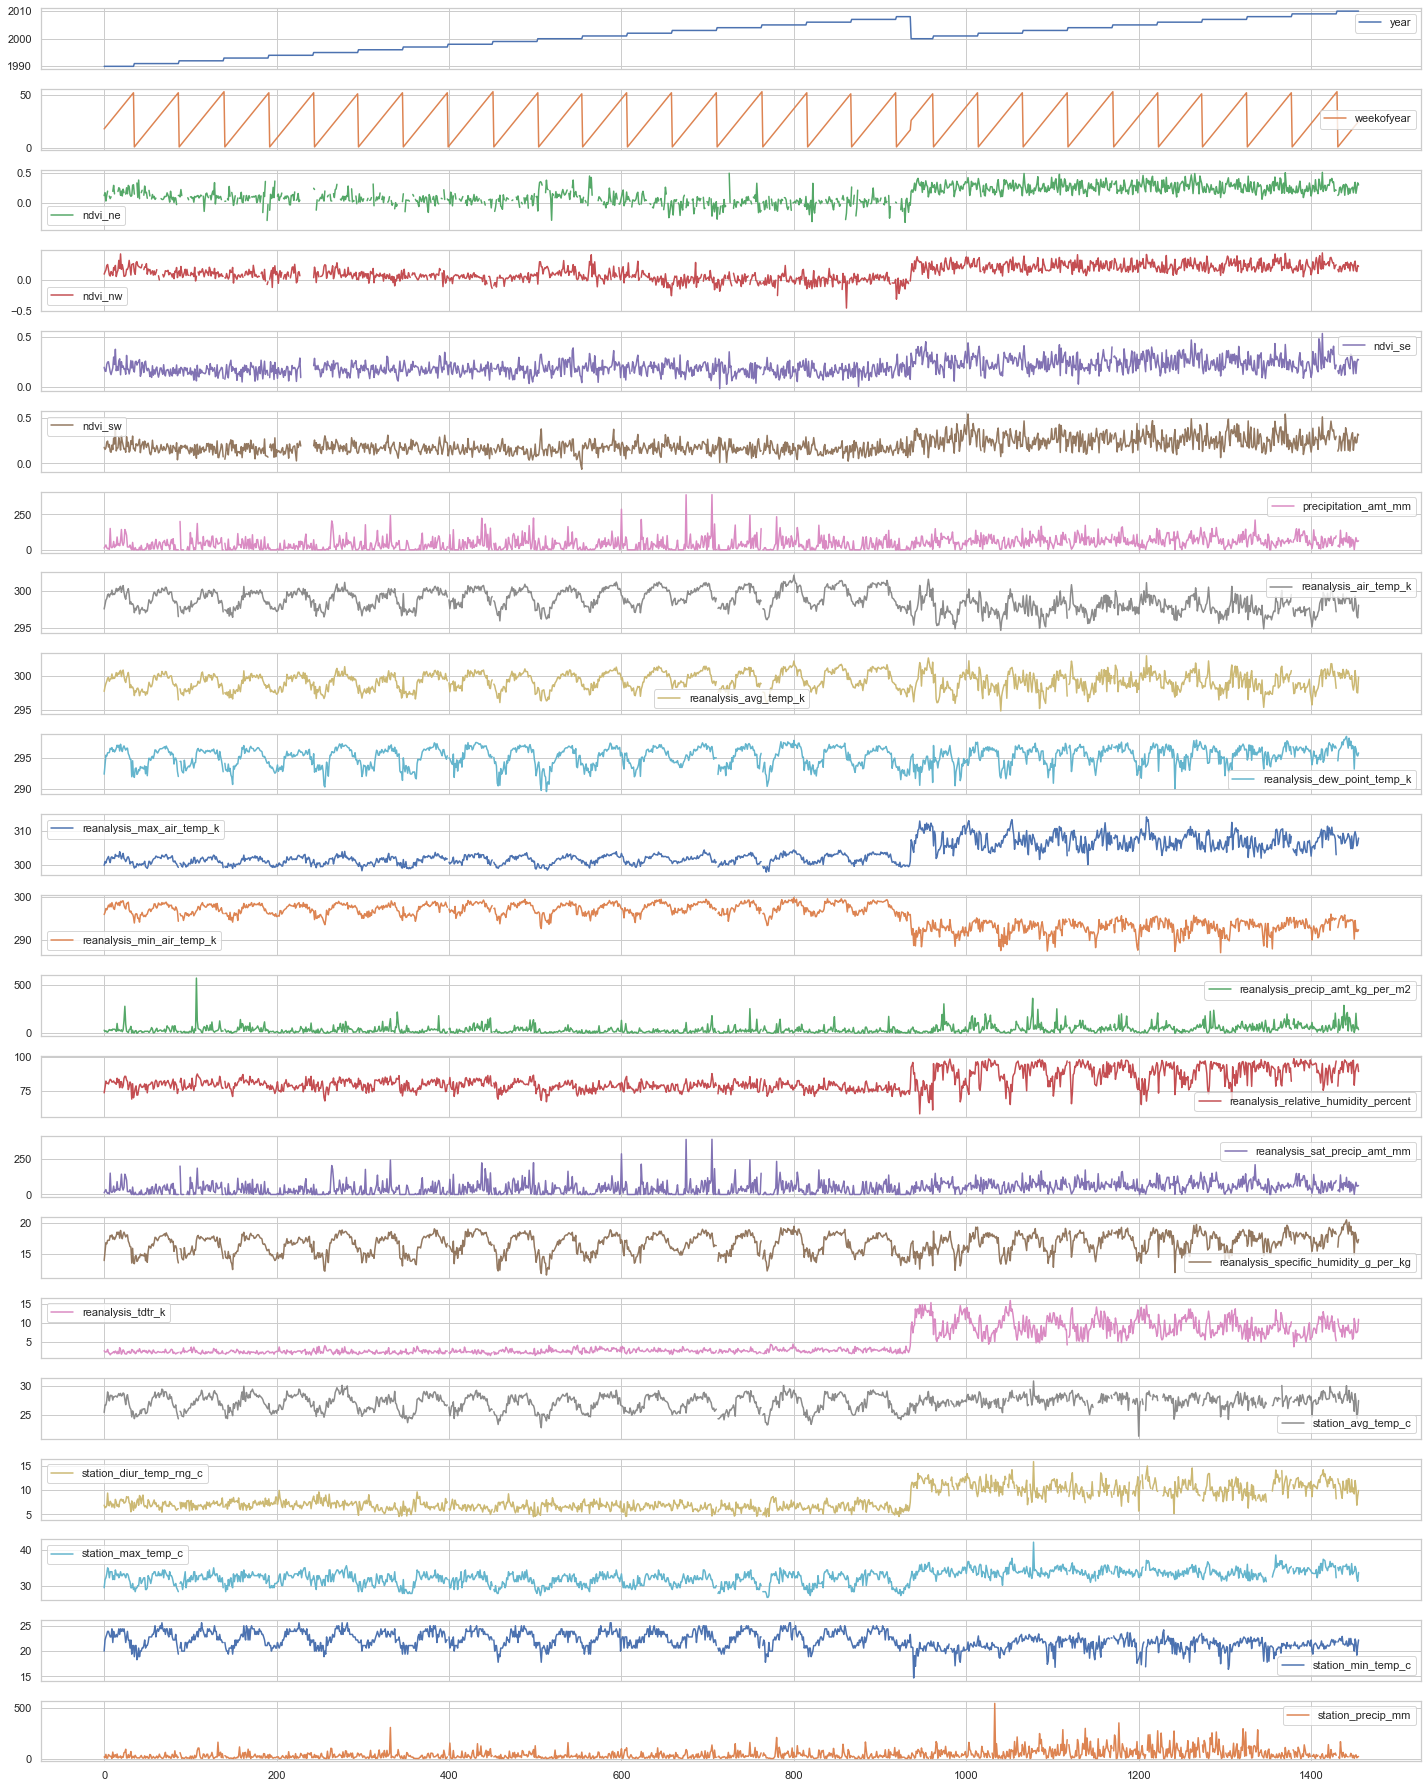

In [17]:
features_train.plot(subplots=True, figsize=(20, 25))

plt.tight_layout()

## Relation to Target Variable

### Scatter plots: Columns vs. total_cases

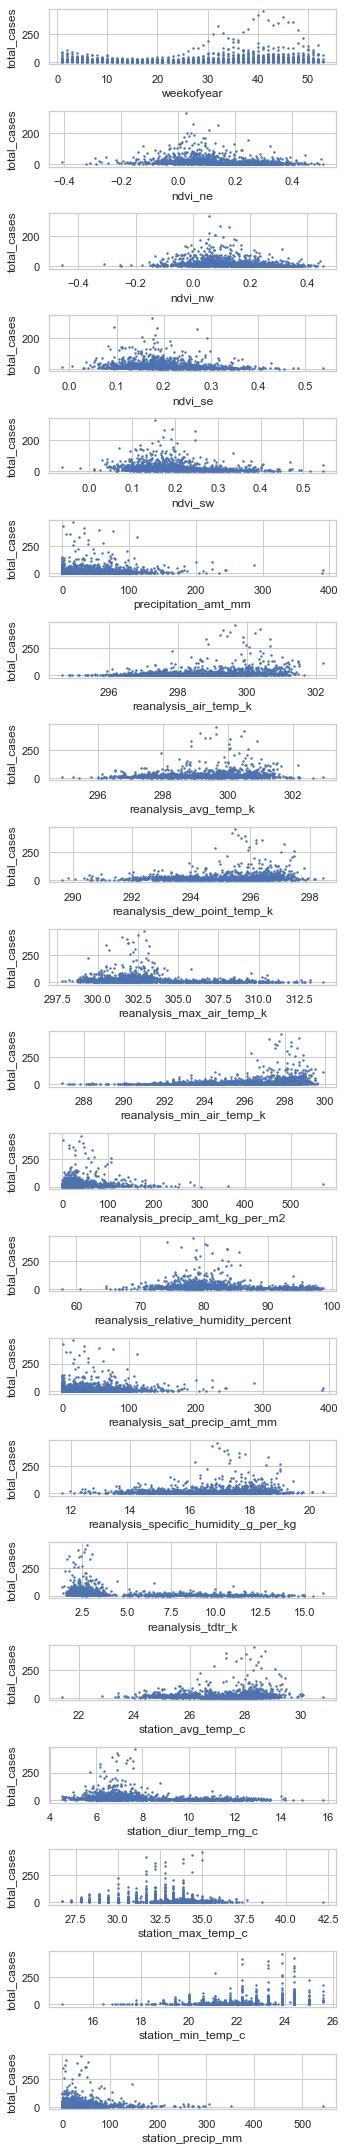

In [6]:
fig, ax = plt.subplots(21)
fig.set_size_inches(5, 30)

df_pcp = features_train.copy().drop(["city", "year", "week_start_date"], axis=1)    # df dropping hard-to-plot attributes and including target variable
df_pcp["total_cases"] = labels_train["total_cases"]

cols = list(df_pcp.columns)
cols.remove("total_cases")

for i, col in enumerate(cols):
    ax[i].scatter(x=df_pcp[col], y=df_pcp["total_cases"], s=2)
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("total_cases")

fig.tight_layout()

### Parallel coordinates plot

In [7]:
import plotly.express as px

fig = px.parallel_coordinates(df_pcp, color="total_cases",
                              dimensions=['station_max_temp_c', 'station_avg_temp_c', 'station_min_temp_c',
                                          'station_diur_temp_rng_c',
                                          "reanalysis_dew_point_temp_k",
                                          "reanalysis_relative_humidity_percent",
                                          "station_precip_mm",
                                          "ndvi_ne",
                                          "ndvi_sw",
                                          "total_cases"],
                              labels={"station_max_temp_c": "Max Temp",
                                      "station_avg_temp_c": "Avg Temp",
                                      "station_min_temp_c": "Min Temp",
                                      "station_diur_temp_rng_c": "Temp Rng",
                                      "reanalysis_dew_point_temp_k": "Dew Point Temp",
                                      "reanalysis_relative_humidity_percent": "Humidity",
                                      "station_precip_mm": "Precip",
                                      "ndvi_ne": "Vegetation NE",
                                      "ndvi_sw": "Vegetation SW",
                                      "total_cases": "Total Cases"},
                              color_continuous_scale=px.colors.sequential.Reds)

fig.write_html("plotly_pcp.html")
fig.show()

### Correlation

<AxesSubplot:>

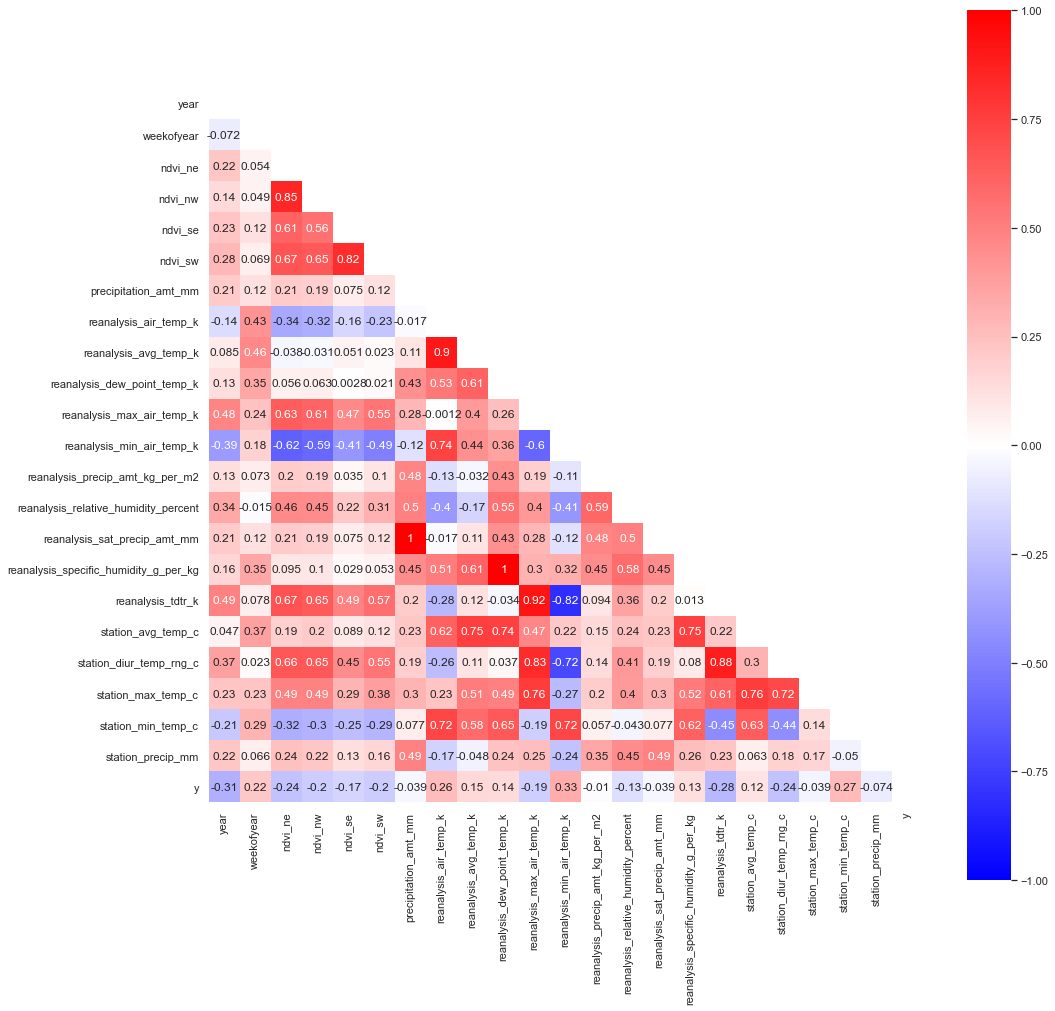

In [8]:
# Correlation - all
helper = features_train.copy()
helper["y"] = labels_train["total_cases"]
corr = helper.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))  # mask to only show lower rectangle
plt.figure(figsize=(16, 16))
sns.heatmap(corr, square=True, center=0, mask=mask, cmap="bwr", vmin=-1, vmax=1, annot=True)

Text(0.5, 0, 'Correlation (absolute)')

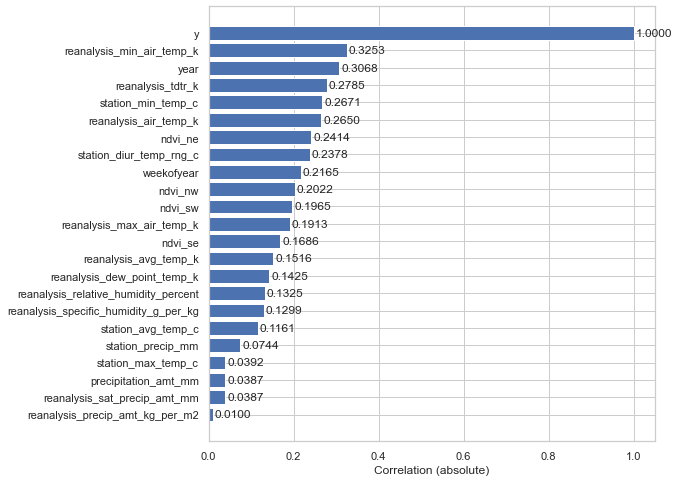

In [13]:
# Correlation - only to target variable (weekly dengue fever cases)
corrs_y = corr["y"].abs().sort_values()

plt.figure(figsize=(8, 8))
fig = plt.barh(y=range(len(corrs_y)), width=corrs_y, tick_label=list(corrs_y.index))
plt.bar_label(fig, padding=2, fmt="%.4f")
plt.xlabel("Correlation (absolute)")

## Missing values

Text(0.5, 0, 'Number of NaN values')

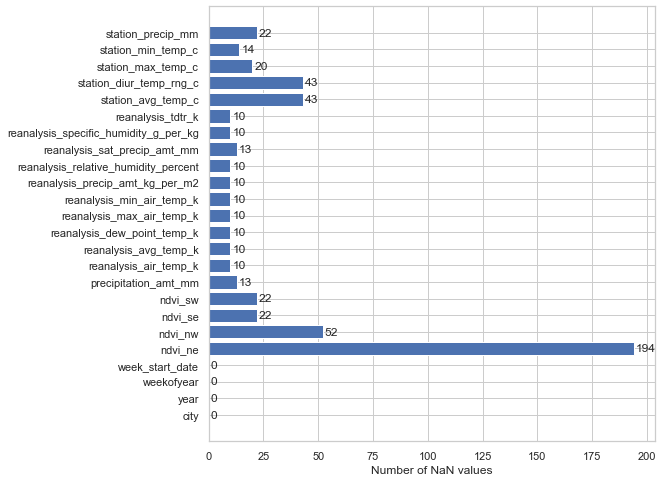

In [44]:
plt.figure(figsize=(8, 8))
fig = plt.barh(y=range(len(features_train.columns)), width=features_train.isna().sum(axis="rows"), tick_label=features_train.columns)
plt.bar_label(fig, padding=2)
plt.xlabel("Number of NaN values")

In [15]:
print("NaN values in labels")
labels_train.isna().sum()

NaN values in labels


city           0
year           0
weekofyear     0
total_cases    0
dtype: int64

Text(0.5, 1.0, 'Weekofyear analysis for missing data')

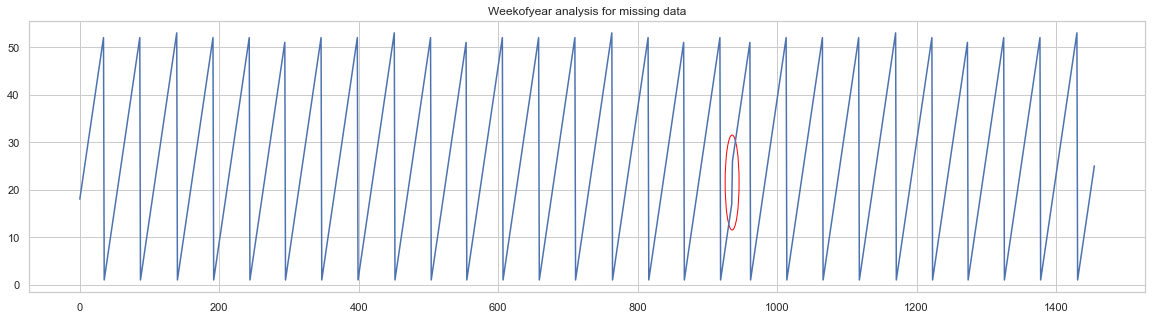

In [45]:
# Verify that there are no weeks of data missing
fig, ax = plt.subplots()
features_train["weekofyear"].plot(figsize=(20,5), ax=ax)

# Highlight change from SJ to IQ
highlight = plt.Circle(xy=(935.5, 21.5), radius=10, color="red", fill=False)
ax.add_artist(highlight)

ax.set_title("Weekofyear analysis for missing data")

## Fourier analysis (seasonality)

Text(0.5, 1.0, 'Fourier analysis for Iquitos and San Juan Dengue Fever Cases')

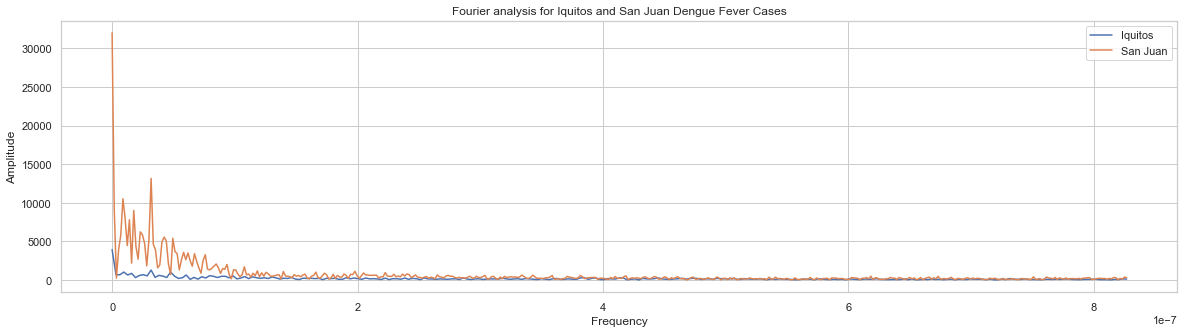

In [50]:
# Fourier analysis to uncover seasonality
SAMPLE_RATE = 1 / (60*60*24*7)  # data sampled once per week -> conversion to Hz = 1/s

# Fourier transform
yf_iquitos = np.abs(rfft(y_iquitos.to_numpy()))
yf_san_juan = np.abs(rfft(y_san_juan.to_numpy()))

# Frequency information
xf_iquitos = rfftfreq(len(y_iquitos), 1/SAMPLE_RATE)
xf_san_juan = rfftfreq(len(y_san_juan), 1/SAMPLE_RATE)

# Plot
plt.figure(figsize=(20, 5))

plt.plot(xf_iquitos, yf_iquitos, label="Iquitos")
plt.plot(xf_san_juan, yf_san_juan, label="San Juan")

plt.xlabel("Frequency")
plt.ylabel("Amplitude")
plt.legend()
plt.title(f"Fourier analysis for Iquitos and San Juan Weekly Dengue Fever Cases")

### Top frequencies

Top 5 frequencies (highest amplitude):

Iquitos
                 amplitude  repetition [days]
frequency                                   
0.000000e+00  3934.000000                inf
3.179691e-08  1290.546143         364.000000
9.539072e-09  1031.246948        1213.333374
4.769536e-08  1022.418457         242.666672
1.589845e-08   860.812683         728.000000


San Juan
                  amplitude  repetition [days]
frequency                                    
0.000000e+00  31993.000000                inf
3.179691e-08  13151.448242         364.000000
8.832474e-09  10521.458008        1310.400024
1.766495e-09   9070.603516        6552.000000
1.766495e-08   9007.288086         655.200012


Text(0.5, 1.0, 'Frequency spectrogram of Iquitos Dengue Fever data')

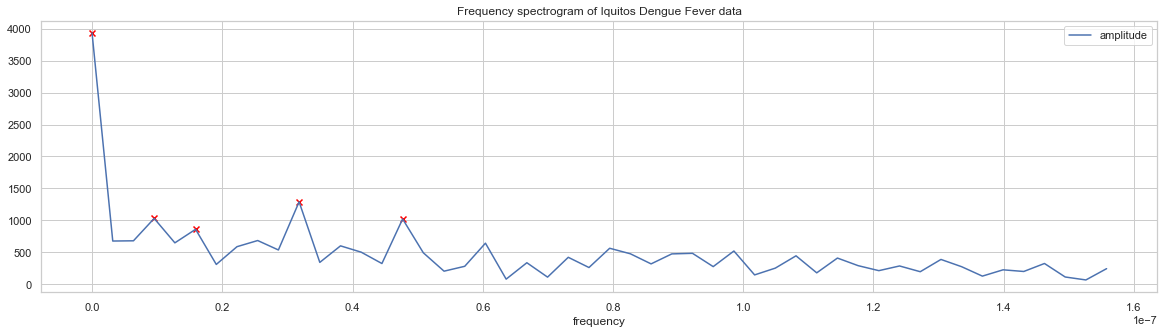

In [55]:
fft_results_iquitos = pd.concat([pd.Series(xf_iquitos), pd.Series(yf_iquitos)], axis=1)
fft_results_iquitos.columns = ["frequency", "amplitude"]
fft_results_san_juan = pd.concat([pd.Series(xf_san_juan), pd.Series(yf_san_juan)], axis=1)
fft_results_san_juan.columns = ["frequency", "amplitude"]

# Add repetition (days)
fft_results_iquitos["repetition [days]"] = (1 / fft_results_iquitos["frequency"]) / (60*60*24)
fft_results_iquitos = fft_results_iquitos.astype("float32")
fft_results_san_juan["repetition [days]"] = (1 / fft_results_san_juan["frequency"]) / (60*60*24)
fft_results_san_juan = fft_results_san_juan.astype("float32")

# Get top frequencies
N = 3
print(f"Top {N} frequencies (highest amplitude):")
top_frequencies_iquitos = fft_results_iquitos.groupby("frequency").max().sort_values("amplitude", ascending=False).head(N)
print("\nIquitos\n", top_frequencies_iquitos)
top_frequencies_san_juan = fft_results_san_juan.groupby("frequency").max().sort_values("amplitude", ascending=False).head(N)
print("\n\nSan Juan\n", top_frequencies_san_juan)

# Plot Iquitos top frequencies
fft_results_iquitos[:50].plot(x="frequency", y="amplitude", figsize=(20, 5))   # Zoom in to interesting frequencies
plt.scatter(x=top_frequencies_iquitos.index, y=top_frequencies_iquitos["amplitude"], marker="x", c="red")  # Highlight top frequencies
plt.title("Frequency spectrogram of Iquitos Dengue Fever data")

# 3) Data Preparation

## General preparation

In [22]:
# Drop bad predictors
columns_to_drop = ["year", "week_start_date"]
X_train = features_train.drop(columns_to_drop, axis="columns")

column_names = X_train.columns

# Encode 'city'
#X_train["city"] = X_train["city"].apply(lambda x: 0 if (x == "sj") else 1)

# Treat NaN
X_train.fillna(method="ffill", inplace=True)

# Scale for LSTM (see https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)
#scaler = MinMaxScaler(feature_range=(0, 1))
#X_train = scaler.fit_transform(X_train)

# Re-cast to Dataframe
X_train = pd.DataFrame(X_train, columns=column_names)

# Get labels only (for convenience)
y_train = labels_train["total_cases"]

# Split into San Juan and Iquitos
X_san_juan = X_train[X_train["city"] == "sj"].drop("city", axis=1)
X_iquitos = X_train[X_train["city"] == "iq"].drop("city", axis=1)

# Use only relevant cols
cols_to_use = ["weekofyear",
               "reanalysis_dew_point_temp_k",
               "station_min_temp_c",
               "reanalysis_relative_humidity_percent",
               "reanalysis_tdtr_k"]
X_san_juan = X_san_juan[cols_to_use]
X_iquitos = X_iquitos[cols_to_use]

# Train/dev/test split (60/20/20)
#    Iquitos
split_idx1 = round(0.6*len(X_iquitos))
split_idx2 = round(0.8*len(X_iquitos))
X_iquitos_train, X_iquitos_dev, X_iquitos_test = X_iquitos[:split_idx1], X_iquitos[split_idx1:split_idx2], X_iquitos[split_idx2:]
y_iquitos_train, y_iquitos_dev, y_iquitos_test = y_iquitos[:split_idx1], y_iquitos[split_idx1:split_idx2], y_iquitos[split_idx2:]
#    San Juan
split_idx1 = round(0.6*len(X_san_juan))
split_idx2 = round(0.8*len(X_san_juan))
X_sj_train, X_sj_dev, X_sj_test = X_san_juan[:split_idx1], X_san_juan[split_idx1:split_idx2], X_san_juan[split_idx2:]
y_sj_train, y_sj_dev, y_sj_test = y_san_juan[:split_idx1], y_san_juan[split_idx1:split_idx2], y_san_juan[split_idx2:]

X_sj_train.head()

weekofyear  reanalysis_dew_point_temp_k  station_min_temp_c  \
0          18                   292.414286                20.0   
1          19                   293.951429                22.2   
2          20                   295.434286                22.8   
3          21                   295.310000                23.3   
4          22                   295.821429                23.9   

   reanalysis_relative_humidity_percent  reanalysis_tdtr_k  
0                             73.365714           2.628571  
1                             77.368571           2.371429  
2                             82.052857           2.300000  
3                             80.337143           2.428571  
4                             80.460000           3.014286

## Model-specific preparation

In [23]:
# Change value here
###########################
CITY = "sj"
DO_HYPERPARAMETER_TESTING = True
# Past time periods to consider (time periods are weeks)
LOOK_BACK_Y = 1     # past dengue fever cases time periods (`AR` order in SARIMAX)
LOOK_BACK_X = 0     # all columns past time periods to consider (`MA` order in SARIMAX)
###########################

y_ground_truth = y_san_juan if (CITY == "sj") else y_iquitos


def add_X_history(X: pd.DataFrame, look_back: int = 1, fillna=0) -> pd.DataFrame:
    """Add past timesteps for all columns."""
    df = X.copy()
    cols = df.columns

    if look_back is not None:
        for col in cols:
            for i in range(1, look_back + 1):
                df[f"{col}_t-{i}"] = X[col].shift(i).fillna(fillna)

    return df


def add_y_history(X: pd.DataFrame, y: pd.Series, look_back: int = 1,
                        fillna=0) -> pd.DataFrame:
    """Add past time steps of dependant variable (here, dengue fever cases)."""
    df = X.copy()

    if look_back is not None:
        for i in range(1, look_back + 1):
            df[f"y_t-{i}"] = y.shift(i).fillna(fillna)

    return df


X_train = X_sj_train if (CITY == "sj") else X_iquitos_train
y_train = y_sj_train if (CITY == "sj") else y_iquitos_train
X_dev = X_sj_dev if (CITY == "sj") else X_iquitos_dev
y_dev = y_sj_dev if (CITY == "sj") else y_iquitos_dev
X_test = X_sj_test if (CITY == "sj") else X_iquitos_test
y_test = y_sj_test if (CITY == "sj") else y_iquitos_test

# SARIMAX
SARIMAX_data = {
    "train": {"X": add_X_history(X_train, look_back=LOOK_BACK_X), "y": y_train},
    "dev": {"X": add_X_history(X_dev, look_back=LOOK_BACK_X), "y": y_dev},
    "test": {"X": add_X_history(X_test, look_back=LOOK_BACK_X), "y": y_test}
}

# LSTM
def prepare_for_lstm(X: pd.DataFrame, y: pd.Series = None, look_back_y: int = 1, look_back_X: int = 0,
                     fillna=0) -> tuple[np.ndarray, np.ndarray]:
    df = add_y_history(X, y, look_back_y, fillna)
    df = add_X_history(df, look_back_X, fillna)
    df = np.reshape(df.to_numpy(), (df.shape[0], 1, df.shape[1]))   # Reshape inputs for LSTM

    y_copy = y.copy().reset_index(drop=True).to_numpy()

    return df, y_copy


LSTM_data = {
    "train": dict((key, val) for key, val in zip(["X", "y"], prepare_for_lstm(X_train, y_train, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X))),
    "dev": dict((key, val) for key, val in zip(["X", "y"], prepare_for_lstm(X_dev, y_dev, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X))),
    "test": dict((key, val) for key, val in zip(["X", "y"], prepare_for_lstm(X_test, y_test, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X)))
}

print("Model-specific changes made.")

Model-specific changes made.


# 4) Modelling

## SARIMAX model

ARMA model:

$$y_t = c + \epsilon_t + \Sigma_{i=1}^p a_i y_{t-i} + \Sigma_{j=1}^q b_j \epsilon_{t-j}$$

Integrative (I) approach:

$$\Delta y_t = y_t - y_{t-1}$$

### Parameter selection

In [60]:
%%time

# AR and MA parameters

from warnings import filterwarnings
filterwarnings('ignore')

SARIMAX_hyperparameters = {
    "order_ar": range(6),    # equal to parameter p
    "order_ma": range(6)     # equal to parameter q
}

if DO_HYPERPARAMETER_TESTING:
    best_dev_error = np.inf

    for order_ar in SARIMAX_hyperparameters["order_ar"]:
        for order_ma in SARIMAX_hyperparameters["order_ma"]:
            sarimax_model = sm.tsa.SARIMAX(SARIMAX_data["train"]["y"],
                                           exog=SARIMAX_data["train"]["X"],
                                           order=(order_ar, 1, order_ma),
                                           seasonal_order=(0, 0, 0, 0))
            sarimax_model_results = sarimax_model.fit()

            # Evaluation
            train_set_predictions = sarimax_model_results.predict()
            dev_set_predictions = sarimax_model_results.forecast(len(SARIMAX_data["dev"]["y"]),
                                                                 exog=SARIMAX_data["dev"]["X"])

            train_error = mean_absolute_error(SARIMAX_data["train"]["y"], train_set_predictions)
            dev_error = mean_absolute_error(SARIMAX_data["dev"]["y"], dev_set_predictions)

            if dev_error <= best_dev_error: # evaluate base don dev_error
                best_dev_error = dev_error
                print(f"\nAR={order_ar}, MA={order_ma}")
                print(f"Train MAE={train_error} | Dev MAE={dev_error}")

    print("Finished hyperparam search.")
else:
    print("Skipped SARIMAX hyperparam search.")


AR=0, MA=0
Train MAE=10.421532812403155 | Dev MAE=11.83278816750022

AR=0, MA=1
Train MAE=10.246879528480964 | Dev MAE=11.772634154165134

AR=1, MA=0
Train MAE=10.246478766054025 | Dev MAE=11.764744567993333

AR=1, MA=1
Train MAE=10.24380849030805 | Dev MAE=11.569679735124433
Finished hyperparam search.
Wall time: 41.6 s


<AxesSubplot:>

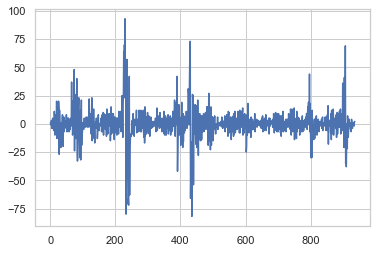

In [71]:
# I (integrative) parameter
y_ground_truth.diff(1).plot()

### Train model

In [61]:
%%time

ORDER_AR = 1
ORDER_I = 1
ORDER_MA = 1

SARIMAX_X_train_dev = pd.concat([SARIMAX_data["train"]["X"], SARIMAX_data["dev"]["X"]])
SARIMAX_y_train_dev = pd.concat([SARIMAX_data["train"]["y"], SARIMAX_data["dev"]["y"]])

sarimax_model = sm.tsa.SARIMAX(SARIMAX_y_train_dev,
                               exog=SARIMAX_X_train_dev,
                               order=(ORDER_AR, ORDER_I, ORDER_MA),
                               seasonal_order=(0, 0, 0, 0))
sarimax_model_results = sarimax_model.fit()

print(sarimax_model_results.summary())

                               SARIMAX Results                                
Dep. Variable:            total_cases   No. Observations:                  749
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3024.227
Date:                Mon, 05 Jul 2021   AIC                           6064.454
Time:                        21:07:58   BIC                           6101.393
Sample:                             0   HQIC                          6078.689
                                - 749                                         
Covariance Type:                  opg                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
weekofyear                               0.0109      0.072      0.152      0.879      -0.129       0.151
reanalysis_dew_point_temp_k              1.6304      

## LSTM Model

### Hyperparameter tuning

In [19]:
learning_rate_vals = [1e-4, 3e-4, 6e-4,
                      1e-3, 3e-3, 6e-3,
                      1e-2, 3e-2, 6e-2,
                      1e-1, 3e-1, 6e-1]
lambda_vals = [1e-4, 3e-4, 6e-4,
               1e-3, 3e-3, 6e-3,
               1e-2, 3e-2, 6e-2,
               1e-1, 3e-1, 6e-1]

def build_model(hp):
    initializer = tf.keras.initializers.GlorotNormal(seed=SEED)     # Glorot/Xavier: w = randn * sqrt(2 / (fan_in + fan_out))
    regularizer = tf.keras.regularizers.l2(
        hp.Choice("l2", values=lambda_vals)
    )

    inputs = tf.keras.Input(shape=(1, LSTM_data["train"]["X"].shape[2]))
    hidden1 = layers.LSTM(30,
                      kernel_initializer=initializer,
                      kernel_regularizer=regularizer)(inputs)
    hidden2 = layers.Dense(30,
                           kernel_initializer=initializer,
                           kernel_regularizer=regularizer)(hidden1)
    hidden3 = layers.Dense(30,
                           kernel_initializer=initializer,
                           kernel_regularizer=regularizer)(hidden2)
    hidden4 = layers.Dense(10,
                           kernel_initializer=initializer,
                           kernel_regularizer=regularizer)(hidden3)
    output = layers.Dense(1,
                          kernel_initializer=initializer,
                          kernel_regularizer=regularizer)(hidden4)
    model = tf.keras.Model(inputs=inputs, outputs=output)
    model.compile(loss="mean_absolute_error",
                  optimizer=tf.keras.optimizers.Adam(
                      hp.Choice("learning_rate",
                                values=learning_rate_vals))
                  )

    return model

print("Model set up.")

Model set up.


In [73]:
class CustomTuner(kerastuner.tuners.BayesianOptimization):
    """To tune epochs and batch_size. Idea from https://kegui.medium.com/how-to-tune-the-number-of-epochs-and-batch-size-in-keras-tuner-c2ab2d40878d"""
    def run_trial(self, trial, *args, **kwargs):
        #kwargs["batch_size"] = trial.hyperparameters.Choice("batch_size", values=[64, 128, 256, 512])
        kwargs["epochs"] = trial.hyperparameters.Int("epochs", 10, 50, step=10)
        super().run_trial(trial, *args, **kwargs)


tuner = CustomTuner(
    build_model,
    seed=SEED,
    objective='val_loss',
    max_trials=100,
    executions_per_trial=1
)

if DO_HYPERPARAMETER_TESTING:
    tuner.search(LSTM_data["train"]["X"], LSTM_data["train"]["y"], validation_data=(LSTM_data["dev"]["X"], LSTM_data["dev"]["y"]),
                 batch_size=LSTM_data["train"]["X"].shape[0])

    tuner.results_summary()

    models = tuner.get_best_models(10)
    best_model = models[0]

    print("\n\n\nBest model:")
    print(best_model.summary())
    print("\nHyperparameters chosen:")
    print(tuner.get_best_hyperparameters()[0].values)
else:
    print("No hyperparameter testing executed.")

Trial 12 Complete [00h 00m 03s]
val_loss: 12.9633150100708

Best val_loss So Far: 4.973644256591797
Total elapsed time: 00h 00m 46s
Results summary
Results in .\untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
l2: 0.001
learning_rate: 0.01
epochs: 40
Score: 4.973644256591797
Trial summary
Hyperparameters:
l2: 0.001
learning_rate: 0.01
epochs: 50
Score: 4.973644256591797
Trial summary
Hyperparameters:
l2: 0.0001
learning_rate: 0.03
epochs: 30
Score: 4.977883815765381
Trial summary
Hyperparameters:
l2: 0.0001
learning_rate: 0.006
epochs: 40
Score: 5.143304824829102
Trial summary
Hyperparameters:
l2: 0.0001
learning_rate: 0.06
epochs: 40
Score: 5.14845085144043
Trial summary
Hyperparameters:
l2: 0.001
learning_rate: 0.1
epochs: 50
Score: 5.225777626037598
Trial summary
Hyperparameters:
l2: 0.0006
learning_rate: 0.01
epochs: 30
Score: 5.461845397949219
Trial summary
Hyperparameters:
l2: 0.0001
learning_rate: 0.1
epochs: 50
S

In [24]:
# Retrain on training and dev sets
X_retrain = pd.concat([pd.DataFrame(LSTM_data["train"]["X"][:, 0, :]), pd.DataFrame(LSTM_data["dev"]["X"][:, 0, :])])
y_retrain = pd.concat([pd.Series(LSTM_data["train"]["y"]), pd.Series(LSTM_data["dev"]["y"])])
X_retrain, y_retrain = prepare_for_lstm(X_retrain, y_retrain, look_back_y=None, look_back_X=None)     # look_back already added before

# Parameters
LEARNING_RATE = 0.01
BATCH_SIZE = X_retrain.shape[0]     # use entire dataset
EPOCHS = 40
LAMBDA = 0.001

initializer = tf.keras.initializers.GlorotNormal(seed=SEED)     # Glorot/Xavier: w = randn * sqrt(2 / (fan_in + fan_out))
regularizer = tf.keras.regularizers.l2(LAMBDA)

inputs = tf.keras.Input(shape=(1, LSTM_data["train"]["X"].shape[2]))
hidden1 = layers.LSTM(30,
                      kernel_initializer=initializer,
                      kernel_regularizer=regularizer)(inputs)
hidden2 = layers.Dense(30,
                       kernel_initializer=initializer,
                       kernel_regularizer=regularizer)(hidden1)
hidden3 = layers.Dense(30,
                       kernel_initializer=initializer,
                       kernel_regularizer=regularizer)(hidden2)
hidden4 = layers.Dense(10,
                       kernel_initializer=initializer,
                       kernel_regularizer=regularizer)(hidden3)
output = layers.Dense(1,
                      kernel_initializer=initializer,
                      kernel_regularizer=regularizer)(hidden4)
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(loss="mean_absolute_error",
              optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
              )
model.fit(X_retrain, y_retrain, batch_size=BATCH_SIZE, epochs=EPOCHS,
          shuffle=False)
          #, callbacks=[tf.keras.callbacks.TensorBoard()])

Epoch 1/40
1/1 [==============================] - 2s 2s/step - loss: 36.4740
Epoch 2/40
1/1 [==============================] - 0s 6ms/step - loss: 35.1390
Epoch 3/40
1/1 [==============================] - 0s 0s/step - loss: 33.8003
Epoch 4/40
1/1 [==============================] - 0s 16ms/step - loss: 32.2499
Epoch 5/40
1/1 [==============================] - 0s 0s/step - loss: 30.4886
Epoch 6/40
1/1 [==============================] - 0s 0s/step - loss: 28.6627
Epoch 7/40
1/1 [==============================] - 0s 16ms/step - loss: 26.7768
Epoch 8/40
1/1 [==============================] - 0s 2ms/step - loss: 25.2734
Epoch 9/40
1/1 [==============================] - 0s 0s/step - loss: 24.5460
Epoch 10/40
1/1 [==============================] - 0s 0s/step - loss: 24.5036
Epoch 11/40
1/1 [==============================] - 0s 17ms/step - loss: 23.5887
Epoch 12/40
1/1 [==============================] - 0s 0s/step - loss: 21.4792
Epoch 13/40
1/1 [==============================] - 0s 0s/step - l

# 5) Evaluation

## SARIMAX Evaluation

SARIMAX Re-Train MAE = 8.957341192768606
SARIMAX Test MAE = 17.21916396732686


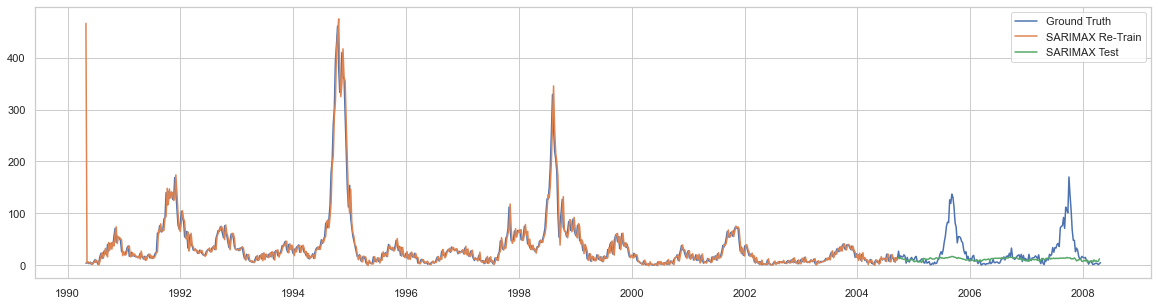

In [75]:
train_set_predictions = sarimax_model_results.predict()
test_set_predictions = sarimax_model_results.forecast(len(SARIMAX_data["test"]["y"]), exog=SARIMAX_data["test"]["X"])
test_set_predictions.index = pd.RangeIndex(train_set_predictions.index[-1], train_set_predictions.index[-1] + len(test_set_predictions), step=1)

# Evaluation
print(f'SARIMAX Re-Train MAE = {mean_absolute_error(SARIMAX_y_train_dev, train_set_predictions)}')
print(f'SARIMAX Test MAE = {mean_absolute_error(SARIMAX_data["test"]["y"], test_set_predictions)}')

ground_truth = pd.concat([train_datetime_index[y_ground_truth.index],
                          y_ground_truth,
                          train_set_predictions,
                          test_set_predictions], axis=1, ignore_index=True)
ground_truth.columns = ["date", "cases_ground_truth", "sarimax_train", "sarimax_test"]

plt.figure(figsize=(20, 5))
plt.plot(ground_truth["date"], ground_truth["cases_ground_truth"], label="Ground Truth")
plt.plot(ground_truth["date"], ground_truth["sarimax_train"], label="SARIMAX Re-Train")
plt.plot(ground_truth["date"], ground_truth["sarimax_test"], label="SARIMAX Test")
plt.legend()

## LSTM evaluation

### San Juan

LSTM Re-Train MAE = 10.576941499722816
LSTM Test MAE = 8.105248407884078


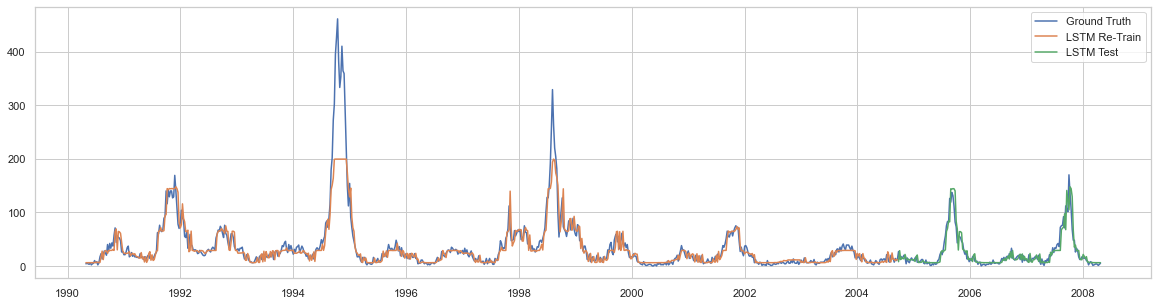

In [77]:
train_index = pd.concat([X_sj_train, X_sj_dev]).index
test_index = X_sj_test.index

X_sj_retrain = pd.concat([pd.DataFrame(X_sj_train), X_sj_dev])
y_sj_retrain = pd.concat([y_sj_train, y_sj_dev])
X_sj_retrain, y_sj_retrain = prepare_for_lstm(X_sj_retrain, y_sj_retrain, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X)     # look_back already added before
X_sj_test_lstm, y_sj_test_lstm = prepare_for_lstm(X_sj_test, y_sj_test, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X)

lstm_train_predict = pd.DataFrame(model.predict(X_sj_retrain)).iloc[:, 0]
lstm_train_predict.index = train_index
lstm_test_predict = pd.DataFrame(model.predict(X_sj_test_lstm)).iloc[:, 0]
lstm_test_predict.index = test_index

print(f"LSTM Re-Train MAE = {mean_absolute_error(y_sj_retrain, lstm_train_predict)}")
print(f'LSTM Test MAE = {mean_absolute_error(y_sj_test_lstm, lstm_test_predict)}')

ground_truth = pd.concat([train_datetime_index[y_san_juan.index],
                          y_san_juan,
                          lstm_train_predict,
                          lstm_test_predict],
                          axis=1, ignore_index=True)
ground_truth.columns = ["date", "cases_ground_truth", "lstm_train", "lstm_test"]

plt.figure(figsize=(20, 5))
plt.plot(ground_truth["date"], y_san_juan, label="Ground Truth")
plt.plot(ground_truth["date"], ground_truth["lstm_train"], label="LSTM Re-Train")
plt.plot(ground_truth["date"], ground_truth["lstm_test"], label="LSTM Test")
plt.legend()

### Iquitos

LSTM Re-Train MAE = 5.977918466696372
LSTM Test MAE = 5.906881832159483


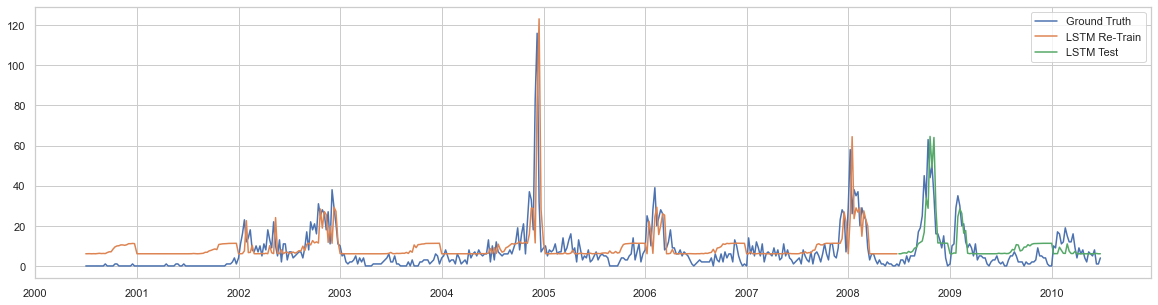

In [76]:
train_index = pd.concat([X_iquitos_train, X_iquitos_dev]).index
test_index = X_iquitos_test.index

X_iq_retrain = pd.concat([pd.DataFrame(X_iquitos_train), X_iquitos_dev])
y_iq_retrain = pd.concat([y_iquitos_train, y_iquitos_dev])
X_iq_retrain, y_iq_retrain = prepare_for_lstm(X_iq_retrain, y_iq_retrain, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X)     # look_back already added before
X_iq_test_lstm, y_iq_test_lstm = prepare_for_lstm(X_iquitos_test, y_iquitos_test, look_back_y=LOOK_BACK_Y, look_back_X=LOOK_BACK_X)

lstm_train_predict = pd.DataFrame(model.predict(X_iq_retrain)).iloc[:, 0]
lstm_train_predict.index = train_index
lstm_test_predict = pd.DataFrame(model.predict(X_iq_test_lstm)).iloc[:, 0]
lstm_test_predict.index = test_index

print(f"LSTM Re-Train MAE = {mean_absolute_error(y_iq_retrain, lstm_train_predict)}")
print(f'LSTM Test MAE = {mean_absolute_error(y_iq_test_lstm, lstm_test_predict)}')

ground_truth = pd.concat([train_datetime_index[y_iquitos.index],
                          y_iquitos,
                          lstm_train_predict,
                          lstm_test_predict],
                          axis=1, ignore_index=True)
ground_truth.columns = ["date", "cases_ground_truth", "lstm_train", "lstm_test"]

plt.figure(figsize=(20, 5))
plt.plot(ground_truth["date"], y_iquitos, label="Ground Truth")
plt.plot(ground_truth["date"], ground_truth["lstm_train"], label="LSTM Re-Train")
plt.plot(ground_truth["date"], ground_truth["lstm_test"], label="LSTM Test")
plt.legend()

# (Apply to provided test data)

In [78]:
previous = 0
predictions = []

# TODO: SJ and IQ getrennt
features_test_sj = features_test[features_test["city"] == "sj"]
features_test_sj = features_test_sj[cols_to_use]
features_test_sj.fillna(method="ffill", inplace=True)
#scaler = MinMaxScaler(feature_range=(0, 1))
#features_test_sj = scaler.fit_transform(features_test_sj)

for row in features_test_sj.iterrows():
    row = row[1]
    row["y_t-1"] = previous
    row = np.reshape(row.to_numpy(), (1, 1, len(row)))

    prediction = model.predict(row)[0][0]

    predictions.append(prediction)
    previous = prediction

predictions

[6.050053,
 6.1455617,
 6.1025376,
 6.1121283,
 6.126858,
 6.1500983,
 6.1433454,
 6.1592107,
 6.192961,
 6.289717,
 6.3103843,
 6.612332,
 6.710379,
 7.0084634,
 7.589734,
 8.626354,
 9.932483,
 10.867258,
 11.273134,
 11.391077,
 11.465609,
 11.5114155,
 11.501432,
 11.556998,
 11.526592,
 11.562072,
 11.60475,
 11.526972,
 11.48854,
 11.525543,
 11.581497,
 11.632803,
 11.637638,
 11.56575,
 11.536646,
 10.002907,
 7.7712827,
 6.6953096,
 6.3427796,
 6.2895703,
 6.2671824,
 6.2945266,
 6.316792,
 6.3168454,
 6.2567477,
 6.3007073,
 6.292723,
 6.1737905,
 6.2371225,
 6.1857963,
 6.159644,
 6.155978,
 6.1731043,
 6.157815,
 6.1595273,
 6.158554,
 6.144411,
 6.142383,
 6.162016,
 6.193292,
 6.201939,
 6.322222,
 6.294025,
 6.6685896,
 6.7754498,
 6.941264,
 7.7764983,
 8.732528,
 10.2841015,
 11.187828,
 11.315292,
 11.443529,
 11.47133,
 11.5194645,
 11.529299,
 11.572807,
 11.526851,
 11.553883,
 11.554541,
 11.553971,
 11.568373,
 11.480421,
 11.466579,
 11.517414,
 11.546577,
 11.5

<AxesSubplot:>

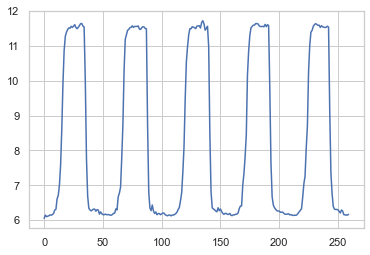

In [79]:
pd.Series(predictions).plot()